In [1]:
import numpy as np
from scipy.optimize import least_squares
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt

from sklearn.gaussian_process.kernels import RBF, Matern
import h5py


source_dataset = "../Datasets/Dataset_forumtracking.hdf5"
final_dataset = "forumtracking.hdf5"

max_trajectory_length = 100
max_nr_trajectories = 100
filter_parameter = ("", 3)

origin = "4"

%run preprocessing.py
# defines:
# filter_by_origin(path, goal, target=None)
# filter_by_length(path, length, target=None)
# filter_by_number(path, number, target=None)
# filter_trajectory(data, kind=None, windowsize=3)
# adjust_trajectory_length(trajectory, length)
# dp_algorithm(tolerance, trajectory)
# dp_cost_function(tolerance, trajectory)
# process_trajectory(trajectory, length, filter_parameter)


/home/clemens/.anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Preprocessing


In [4]:
filter_by_origin(source_dataset, origin, target="forumtracking_reduced.hdf5")
filter_by_length("forumtracking_reduced.hdf5", max_trajectory_length, target=final_dataset)
#filter_by_number("forumtracking_short.hdf5", max_nr_trajectories, target=final_dataset)

os.remove("forumtracking_reduced.hdf5")
#os.remove("forumtracking_short.hdf5")
print("Done")

Done


In [2]:
#img_forum = cv2.imread("../Datasets/Images/forumtracking.png")

i = 0
with h5py.File(final_dataset, "r") as f:
    count_total = f.attrs["TotalNrTrajectories"]
    X_forum = np.zeros((count_total, max_trajectory_length,2))
    y_forum = np.zeros((count_total,))
    for goal in f:
        for traj in f[goal]:
            trajectory = process_trajectory(f[goal+"/"+traj+"/Positions"][:], \
                                                  max_trajectory_length, \
                                                  filter_parameter)
            X_forum[i] = trajectory
            y_forum[i] = int(goal)
            i += 1

(773, 100, 2)


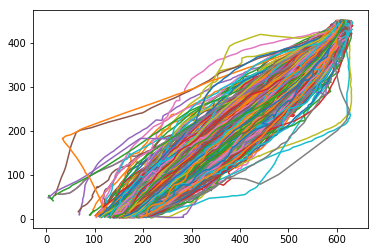

In [3]:
data = X_forum[np.where(y_forum==8)]
print(data.shape)
for traj in data:
    plt.plot(traj[:,0], traj[:,1])
plt.show()

# Mean & Variance

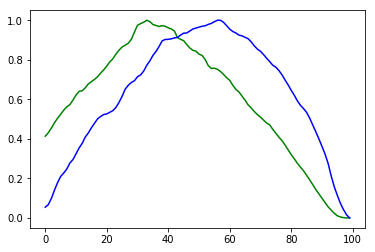

In [4]:
mx = np.mean(data[:,:,0],axis=0)
my = np.mean(data[:,:,1],axis=0)

for traj in data:
    plt.plot(traj[:,0], traj[:,1])
plt.plot(mx,my,linewidth=4,linestyle="--",c="r")
plt.show()

real_x_var = np.var(data[:,:,0],axis=0)
real_y_var = np.var(data[:,:,1],axis=0)

real_x_std = np.std(data[:,:,0],axis=0)
real_y_std = np.std(data[:,:,1],axis=0)

norm_x_var = (real_x_var-np.min(real_x_var))/(np.max(real_x_var)-np.min(real_x_var))
norm_y_var = (real_y_var-np.min(real_y_var))/(np.max(real_y_var)-np.min(real_y_var))

plt.plot(real_x_var,c="g")
plt.plot(real_y_var,c="b")
plt.show()

plt.plot(norm_x_var,c="g")
plt.plot(norm_y_var,c="b")
plt.show()

In [5]:
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111)

ax.set_title("X-Werte")
for i in range(200):
    ax.plot(data[i,:,0], alpha=0.35)
ax.fill_between(range(100), mx - np.sqrt(real_x_var), mx + np.sqrt(real_x_var), alpha=0.75, color='r')
ax.plot(mx,linewidth=6,linestyle="--",c="r")
plt.show()

fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111)
ax.set_title("Y-Werte")
for i in range(200):
    plt.plot(data[i,:,1], alpha=0.35)
ax.plot(my,linewidth=6,linestyle="--",c="r")
ax.fill_between(range(100), my - np.sqrt(real_y_var), my + np.sqrt(real_y_var), alpha=0.99, color='r')
plt.show()

# Create Base-Trajectories

In [6]:
dim_base = 20
n_base = 5

#var_base = 0.5*(1+18*np.sin(np.linspace(0,np.pi,dim_base)))
var_base = 0.5*(1+8*np.exp(-1*np.linspace(-2,2,dim_base)**2))

mx = np.arange(dim_base)
my = np.arange(dim_base)
mean = np.vstack([mx,my]).T + 5
print(len(mean))
print(len(mean)/dim_base)

20
1.0


In [21]:
base = np.zeros((n_base, dim_base, 2))
base[:,0,:] = mean[0]
print(base.shape)

fig = plt.figure(figsize=(16,9))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(mean[:,0],mean[:,1],linewidth=2,linestyle="--",c="k",label=r"Mean $\mu$")
ax2.plot(mean[:,0],mean[:,1],linewidth=2,linestyle="--",c="k",label=r"Mean $\mu$")
ax1.set_xlabel("x")
ax2.set_xlabel("x")
ax1.set_ylabel("y")
ax2.set_ylabel("y")

indices = [int(el) for el in np.linspace(1,len(mean)-1,dim_base)]
print(indices)
for i in range(dim_base): 
    #theta = angle_between(mean[i],mean[i-1])+np.pi*0.5
    i_mean = indices[i]
    theta = get_xangle(mean[i_mean]-mean[i_mean-1])
    print(theta)
    Phi = np.array([[np.cos(theta), np.sin(theta)],[-np.sin(theta), np.cos(theta)]])
 

    line = np.zeros((n_base,2))
    #line[:,0] = np.random.uniform(-0.5, 0.5, n_base)
    line[:,0] = np.sort(np.random.uniform(-var_base[i], var_base[i], n_base))
    #line[:,0] = np.sort(np.random.normal(0, var_base[i], n_base))
    
    rot = mean[i_mean] + np.matmul(Phi,line.T).T

    base[:,i,0] = rot[:,0]
    base[:,i,1] = rot[:,1]
    ax1.plot(rot[:,0],rot[:,1])
    ax1.scatter(rot[:,0],rot[:,1])
    ax2.scatter(rot[:,0],rot[:,1])

ax1.set_title(r"Stuetzpunkte um $\mu$ mit variabler $\sigma$",fontsize=18)
ax2.set_title(r"$\rightarrow$ Stuetz-Trajektorien",fontsize=18)
ax1.set_aspect("equal")
ax2.set_aspect("equal")
ax1.legend()
ax2.legend()
for i_base in range(n_base):
    ax2.plot(base[i_base,:,0], base[i_base,:,1])
plt.savefig("simple_example.png", dpi=200)
plt.show()

(5, 20, 2)
[1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
0.7853981633974483
0.7853981633974483
0.7853981633974483
0.7853981633974483
0.7853981633974483
0.7853981633974483
0.7853981633974483
0.7853981633974483
0.7853981633974483
0.7853981633974483
0.7853981633974483
0.7853981633974483
0.7853981633974483
0.7853981633974483
0.7853981633974483
0.7853981633974483
0.7853981633974483
0.7853981633974483
0.7853981633974483
0.7853981633974483


# Add Nicer Trajectory testing

(100,)
(100, 2)


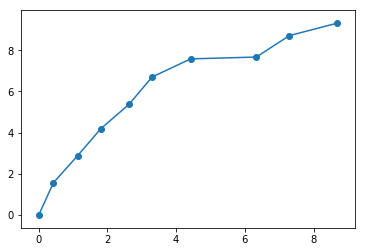

In [78]:
dim_final = 100
var_final = 0.5*(1+4*np.sin(np.linspace(0,np.pi,dim_final)))
print(var_final.shape)

ls_x, ls_y = 1, 1
scale = 1
tmp = base[:,-1,:]
tmp_base = adjust_trajectory_length(tmp, dim_final)
print(tmp_base.shape)
plt.plot(tmp_base[:,0],tmp_base[:,1])
plt.scatter(tmp[:,0],tmp[:,1])
plt.show()

(100, 2)


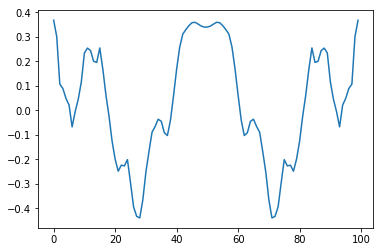

In [128]:
scale = 0.3
cov = Matern(length_scale=.25)(var_final[:,np.newaxis])

rbf_samples = np.zeros((dim_final,2))

rbf_samples[:,0] = np.random.multivariate_normal(mean=np.zeros(dim_final),cov=cov, size=1)*scale
print(rbf_samples.shape)
plt.plot(rbf_samples[:,0])
plt.show()

traj_final = np.zeros((dim_final,2))
traj_final[0,:] = tmp_base[0] + tmp_base[0]

for i in range(1,dim_final):
    theta = angle_between(tmp_base[i],tmp_base[i-1])+np.pi*0.5
    Phi = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
    traj_final[i] = tmp_base[i] + np.matmul(Phi,rbf_samples[i])
    
plt.plot(traj_final[:,0],traj_final[:,1])
plt.scatter(tmp[:,0],tmp[:,1])
plt.show()

# All together!

Mean (100, 2)


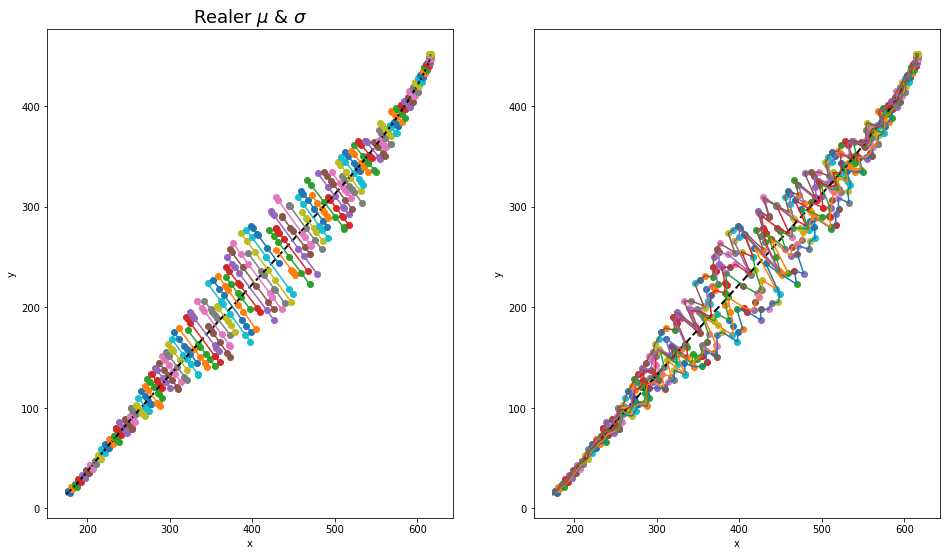

In [12]:
n_total = 30
n_base = 6
assert(n_total%n_base == 0) #fuer spaeter!
n_per_base = int(n_total/n_base)


dim_base = 100
dim_total = 200

#var_base = 0.5*(1+8*np.sin(np.linspace(0,np.pi,dim_base)))
var_base = 0.5*(1+100*np.exp(-1*np.linspace(-2,2,dim_base)**2))

mx = np.mean(data[:,:,0],axis=0)
my = np.mean(data[:,:,1],axis=0)

mean = np.vstack([mx,my]).T + 5

def angle_between(u,v):
    diff = u-v
    return np.arctan2(diff[1],diff[0])%(2*np.pi)

base = np.zeros((n_base, dim_base, 2))
base[:,0,:] = mean[0]
print("Mean",mean.shape)

for i in range(1,dim_base): 
    theta = angle_between(mean[i],mean[i-1])+np.pi*0.5
    Phi = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
    
    line = np.zeros((n_base,2))
    #line[:,0] = np.sort(np.random.uniform(-var_base[i], var_base[i], n_base))
    line[:,0] = np.sort(np.random.normal(0, var_base[i], n_base))
    rot = mean[i] + np.matmul(Phi,line.T).T
    base[:,i,0] = rot[:,0]
    base[:,i,1] = rot[:,1]
    
fig = plt.figure(figsize=(16,9))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(mean[:,0],mean[:,1],linewidth=2,linestyle="--",c="k")
ax2.plot(mean[:,0],mean[:,1],linewidth=2,linestyle="--",c="k")
ax1.set_xlabel("x")
ax2.set_xlabel("x")
ax1.set_ylabel("y")
ax2.set_ylabel("y")
for i in range(1,dim_base): 
    theta = angle_between(mean[i],mean[i-1])+np.pi*0.5
    Phi = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
 

    line = np.zeros((n_base,2))
    #line[:,0] = np.random.uniform(-0.5, 0.5, n_base)
    line[:,0] = np.sort(np.random.uniform(-var_base[i], var_base[i], n_base))
    #line[:,0] = np.sort(np.random.normal(0, var_base[i], n_base))
    
    rot = mean[i] + np.matmul(Phi,line.T).T

    base[:,i,0] = rot[:,0]
    base[:,i,1] = rot[:,1]
    ax1.plot(rot[:,0],rot[:,1])
    ax1.scatter(rot[:,0],rot[:,1])
    ax2.scatter(rot[:,0],rot[:,1])
ax1.set_title(r"Realer $\mu$ & $\sigma$",fontsize=18)
for i_base in range(n_base):
    ax2.plot(base[i_base,:,0], base[i_base,:,1])
plt.savefig("base_trajectories.png", dpi=200)
plt.show()

In [125]:
#################################################################################
var_final = 0.5*(1+4*np.sin(np.linspace(0,np.pi,dim_total)))

final = np.zeros((n_total, dim_total,2))

print("Final ",final.shape)
print("Base ",base.shape)

#final[:,0,:] = base[:,0,:]
#count = 0

for i_base in range(n_base):
    long_base = adjust_trajectory_length(base[i_base,:,:], dim_total)
    final[n_per_base*(i_base):n_per_base*(i_base+1),0,:] = base[i_base,0,:] #Initial Positions

    scale = 3
    cov = Matern(length_scale=15)(np.arange(dim_total)[:,np.newaxis])   
    
    for i_sample in range(n_per_base):
        samples = np.zeros((dim_total,2))
        samples[:,0] = np.random.multivariate_normal(mean=np.zeros(dim_total),cov=cov, size=1)*scale
        
        for i in range(1,dim_total):
            theta = angle_between(long_base[i],long_base[i-1])+np.pi*0.5
            Phi = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
            final[i_base*n_per_base+i_sample,i,:] = long_base[i] + np.matmul(Phi,samples[i])


fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
for i_base in range(n_base):
    ax.plot(base[i_base,:,0], base[i_base,:,1],linestyle="--",c="k",alpha=0.5)
for i in range(n_total):
    ax.plot(final[i,:,0],final[i,:,1])   
ax.set_title("Summe der Stütztrajektorien und der (rotierten) Samples",fontsize=18)
plt.savefig("final_trajectories.png",dpi=200)
plt.show()
print("Done")

Final  (30, 200, 2)
Base  (6, 100, 2)


Done


(1, 100)
(1, 100)
(1, 100)


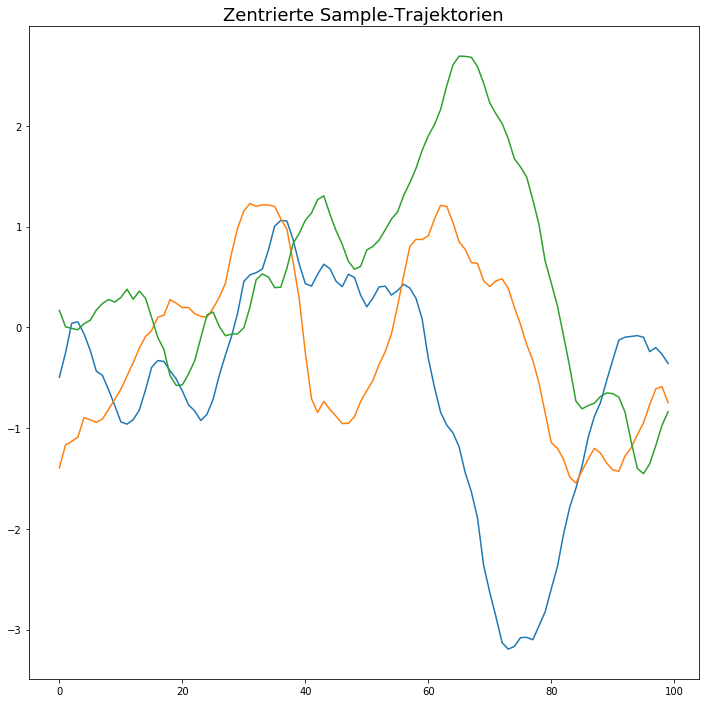

In [124]:
scale = 1
cov = Matern(length_scale=10)(np.arange(100)[:,np.newaxis])   

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)

for i_sample in range(3):
    x = np.random.multivariate_normal(mean=np.zeros(100),cov=cov, size=1)*scale
    print(x.shape)
    ax.plot(x[0])
ax.set_title("Zentrierte Sample-Trajektorien",fontsize=18)
plt.savefig("samples.png",dpi=200)
plt.show()

# Aaaand with real Data!


In [8]:
n_total = 10
dim_total = 200
n_base = 10

assert(n_total%n_base == 0) #fuer spaeter!
n_per_base = int(n_total/n_base)

var_base = 0.5*(4+10*np.sin(np.linspace(0,np.pi,dim_base)))
#var_base = np.zeros((dim_base))+10
#var_base = real_x_std
#plt.plot(var_base)
#plt.show()

mx = np.mean(data[:,:,0],axis=0)
my = np.mean(data[:,:,1],axis=0)
mean = np.vstack([mx,my]).T 

dim_base = len(mean)


def angle_between(u,v):
    diff = u-v
    return np.arctan2(diff[1],diff[0])%(2*np.pi)

base = np.zeros((n_base, dim_base, 2))
base[:,0,:] = mean[0]
print("Base",base.shape)

for i in range(1,dim_base): 
    theta = angle_between(mean[i],mean[i-1])+np.pi*0.5
    Phi = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
    
    line = np.zeros((n_base,2))
    #line[:,0] = np.sort(np.random.uniform(-var_base[i], var_base[i], n_base))    
    line[:,0] = np.sort(np.random.normal(0, var_base[i], n_base))
    rot = mean[i] + np.matmul(Phi,line.T).T
    base[:,i,0] = rot[:,0]
    base[:,i,1] = rot[:,1]
    

#################################################################################
#var_final = 0.5*(1+4*np.sin(np.linspace(0,np.pi,dim_total)))
#var_final = var_base
scale = .1
length_scale = 50
final = np.zeros((n_total, dim_total,2))

print("Final ",final.shape)
print("Base ",base.shape)

#final[:,0,:] = base[:,0,:]
#count = 0

for i_base in range(n_base):
    long_base = adjust_trajectory_length(base[i_base,:,:], dim_total)
    final[n_per_base*(i_base):n_per_base*(i_base+1),0,:] = base[i_base,0,:] #Initial Positions

    cov = Matern(length_scale=length_scale)(np.arange(dim_total)[:,np.newaxis])   
    
    for i_sample in range(n_per_base):
        samples = np.zeros((dim_total,2))
        samples[:,0] = np.random.multivariate_normal(mean=np.zeros(dim_total),cov=cov, size=1)*scale
        
        for i in range(1,dim_total):
            theta = angle_between(long_base[i],long_base[i-1])+np.pi*0.5
            Phi = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
            
            final[i_base*n_per_base+i_sample,i,:] = long_base[i] + np.matmul(Phi,samples[i])

            
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)

for i in range(n_total):
    ax.plot(final[i,:,0],final[i,:,1])   
for i_base in range(n_base):
    ax.plot(base[i_base,:,0], base[i_base,:,1],linewidth=3,linestyle="--",c="k",alpha=0.2)
plt.show()
print("Done")

plt.plot(np.std(final[:,:,0],axis=0))
plt.show()

NameError: name 'dim_base' is not defined

(5, 100, 2)
(5, 100, 2)
(5, 100, 2)
1


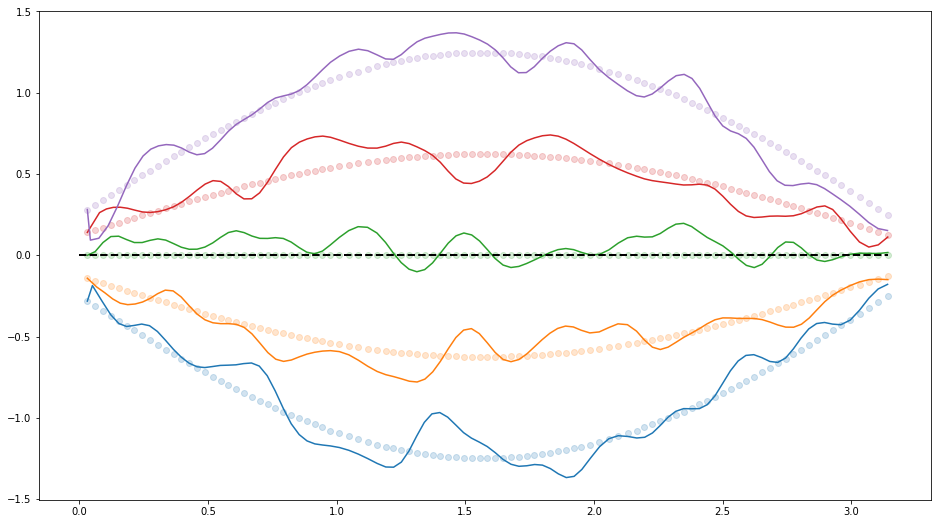

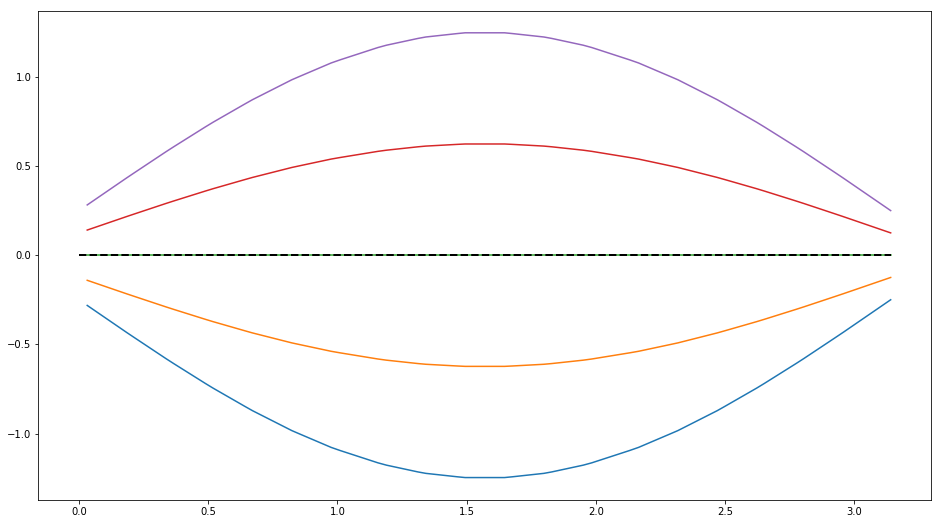

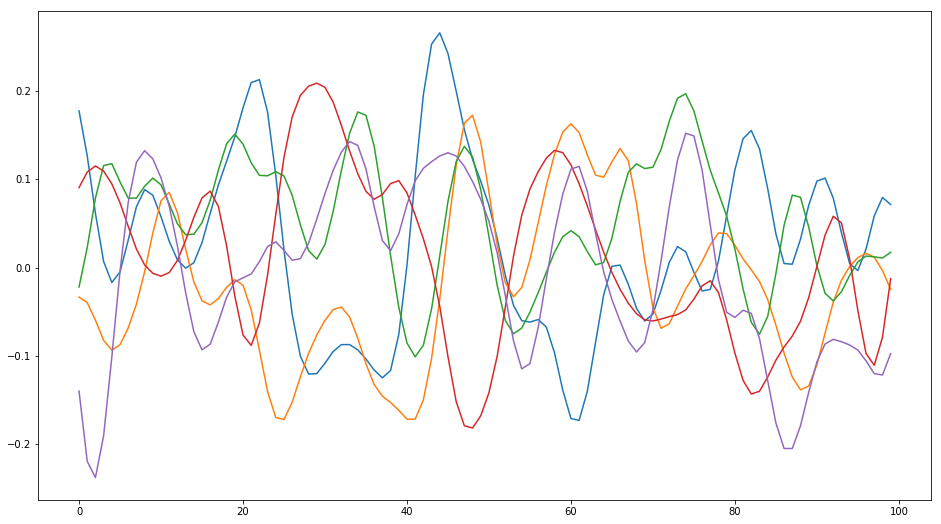

In [97]:
def create_bases(mean, n_base, len_base, var_base, base_type, plot=False):
    base = np.zeros((n_base, len_base, 2))
    base[:,0,:] = mean[0]
    
    indices = [int(el) for el in np.linspace(1,len(mean)-1,len_base)]

    for i in range(len_base): 
        i_mean = indices[i]
        theta = get_xangle(mean[i_mean]-mean[i_mean-1])+0.5*np.pi
        Phi = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])

        line = np.zeros((n_base,2))
        if base_type == "linear":
            line[:,0] = np.linspace(-var_base[i_mean],var_base[i_mean],n_base)
        elif base_type ==  "normal":
            line[:,0] = np.sort(np.random.normal(0, var_base[i], n_base))
        elif base_type ==  "uniform":
            line[:,0] = np.sort(np.random.uniform(-var_base[i], var_base[i], n_base))
        else:
            print("Invalid base_type: ",base_type)
            sys.exit()
        
        rot = mean[i_mean] + np.matmul(Phi,line.T).T
        base[:,i,0] = rot[:,0]
        base[:,i,1] = rot[:,1]
        
    if plot:
        fig = plt.figure(figsize=(16,9))
        ax1 = fig.add_subplot(111)
        ax1.plot(mean[:,0],mean[:,1])
        for n in range(n_base):
            #ax1.scatter(base[n,:,0],base[n,:,1])
            ax1.plot(base[n,:,0],base[n,:,1])
        ax1.plot(mean[:,0],mean[:,1],c="k",linewidth=2,linestyle="--", label="Mean")
        ax1.set_aspect("equal")
        ax1.legend(fontsize=18)
        ax1.set_title("Base Trajectories")
        plt.savefig("Vortrag/bases.png",dpi=200)
        plt.show()
    return base

def adjust_base_length(base, len_total, plot=False):
    adj_bases = np.zeros((base.shape[0], len_total, 2))
    for i in range(base.shape[0]):
        t = np.arange(base.shape[1])
        ti = np.linspace(t.min(), t.max(), len_total)
        fx = interp1d(t, base[i,:,0])
        fy = interp1d(t, base[i,:,1])
        adj_bases[i,:,0] = fx(ti)
        adj_bases[i,:,1] = fy(ti)
    if plot:
        fig = plt.figure(figsize=(16,9))
        ax = fig.add_subplot(111)
        for n in range(base.shape[0]):
            ax.scatter(adj_bases[n,:,0],adj_bases[n,:,1])
        for n in range(len_total):
            ax.plot(adj_bases[:,n,0],adj_bases[:,n,1])
        ax.set_aspect("equal")
        ax.set_title("Adjusted Base Trajectories")
        plt.show()
    return adj_bases
        
        
def create_samples(n_samples, len_sample, length_scale, total_scale, kind="RBF", plot=False):
    mean=np.zeros(len_sample)  
    if kind == "RBF":
        cov = RBF(length_scale=length_scale)(np.arange(len_sample)[:,np.newaxis])  
    elif kind == "Matern":
        cov = Matern(length_scale=length_scale)(np.arange(len_sample)[:,np.newaxis])   
        
    samples = np.zeros((n_samples,len_sample,2))
    samples[:,:,0] = np.random.multivariate_normal(mean=mean, cov=cov, size=n_samples)*total_scale    
    if plot:
        fig = plt.figure(figsize=(12,12))
        ax = fig.add_subplot(111)
        for i in range(n_samples):
            ax.plot(samples[i,:,0])
        ax.set_title("Sample Trajectories")
        plt.show()
    return samples

def combine(base, samples, mean, plot):
    n_per_base = int(n_total/n_base)
    combined = np.zeros((samples.shape[0],samples.shape[1],2))
    #final[]
    print("Mean",mean.shape)
    print("Base",base.shape)
    print("Samples",samples.shape)
    print("combined",combined.shape)
    print("per base: ",n_per_base)
    for i_sample in range(samples.shape[0]):
        i_base = i_sample // n_per_base
        print(i_base,",",i_sample)
        combined[i_sample,0,:] = base[i_base,0,:]
        
        for i in range(1,samples.shape[1]):
            theta = get_xangle(base[i_base,i]-base[i_base,i-1])+0.5*np.pi            
            Phi = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])

            combined[i_sample,i,:] = base[i_base,i] + np.matmul(Phi,samples[i_sample,i])
            #combined[i_sample,i,:] = base[i_base,i] + samples[i_sample,i]
    if plot:
        fig = plt.figure(figsize=(16,9))
        ax = fig.add_subplot(111)
        for n in range(combined.shape[0]):
            ax.plot(combined[n,:,0],combined[n,:,1])
        for n in range(base.shape[0]):
            ax.scatter(base[n,:,0],base[n,:,1],alpha=.2)  
        ax.plot(mean[:,0],mean[:,1],c="k",linewidth=2,linestyle="--")
        ax.set_aspect("equal")
        ax.set_title("Final Trajectories")
        plt.show()        
    return combined

def create_trajectories(mean, n_sample, len_sample, n_base, len_base, base_type, \
                        var_base, length_scale, total_scale, kind="RBF", plot=False):
    assert(n_total%n_base == 0) 
    bases = create_bases(mean, n_base, len_base, var_base, base_type, plot)
    adj_bases = adjust_base_length(bases, len_total, plot)
    samples = create_samples(n_total, len_total, length_scale, total_scale, kind, plot)
    return combine(adj_bases, samples, mean, plot)
    

    
mx = np.mean(data[:,:,0],axis=0)
my = np.mean(data[:,:,1],axis=0)

mean = np.vstack([mx,my]).T
    
n_total = 40
len_total = 100

n_base = 20
len_base = 50

var_base = 0.5*(20+100*np.exp(-1*np.linspace(-2,2,len_base)**2))
base_type = "linear"

length_scale = 10
total_scale = 5
cov_type = "Matern"


mx = np.linspace(0, np.pi,100)
my = np.zeros((100))
mean = np.vstack([mx,my]).T    
n_total = 5
len_total = 100
n_base = 5
len_base = 20
var_base = 0.25+np.sin(mx)
base_type = "linear"

length_scale = 3
total_scale = .1
cov_type = "RBF"

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def get_angle(v1,v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v2 = np.array([1,1])
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))
from math import acos
from math import sqrt
from math import pi

def length(v):
    return sqrt(v[0]**2+v[1]**2)
def dot_product(v,w):
   return v[0]*w[0]+v[1]*w[1]
def determinant(v,w):
   return v[0]*w[1]-v[1]*w[0]
def inner_angle(v,w):
   cosx=dot_product(v,w)/(length(v)*length(w))
   rad=acos(cosx) # in radians
   return rad # returns degrees
def angle_clockwise(A, B):
    #inner=inner_angle(A,B)
    inner_angle = np.arccos(np.dot(A,B) / (np.linalg.norm(A)*np.linalg.norm(B)))
    det = determinant(A,B)
    if det<0: #this is a property of the det. If the det < 0 then B is clockwise of A
        return inner_angle
    else: # if the det > 0 then A is immediately clockwise of B
        return 2*np.pi-inner_angle
    
def combineXXX(base, samples, mean, plot):
    n_per_base = int(samples.shape[0]/base.shape[0])
    combined = np.zeros((samples.shape[0],samples.shape[1],2))
    print(base.shape)
    print(samples.shape)
    print(combined.shape)
    print(n_per_base)
    for i_sample in range(samples.shape[0]):
        i_base = i_sample // n_per_base
        combined[i_sample,0,:] = base[i_base,0,:]
        
        for i in range(1,samples.shape[1]):
            theta = angle_clockwise(base[i_base,i],base[i_base,i-1])+0.5*np.pi            
            Phi = np.array([[np.cos(theta), -1*np.sin(theta)],[np.sin(theta), np.cos(theta)]])
            combined[i_sample,i,:] = base[i_base,i] + np.matmul(Phi,samples[i_sample,i])
    
    return combined

bases = create_bases(mean, n_base, len_base, var_base, base_type, plot=False)
adj_bases = adjust_base_length(bases, len_total, plot=False)
samples = create_samples(n_total, len_total, length_scale, total_scale, cov_type, plot=False)
combined = combineXXX(adj_bases, samples, mean, plot=False)
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)
for n in range(combined.shape[0]):
    ax.plot(combined[n,:,0],combined[n,:,1])
for n in range(adj_bases.shape[0]):
    ax.scatter(adj_bases[n,:,0],adj_bases[n,:,1],alpha=.2)  
ax.plot(mean[:,0],mean[:,1],c="k",linewidth=2,linestyle="--")
#ax.set_aspect("equal")
#ax.set_title("Final Trajectories")
plt.savefig("Vortrag/combined.png",dpi=200)
plt.show()  

fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)
for n in range(adj_bases.shape[0]):
    ax.plot(adj_bases[n,:,0],adj_bases[n,:,1])

ax.plot(mean[:,0],mean[:,1],c="k",linewidth=2,linestyle="--")
#ax.set_aspect("equal")
plt.savefig("Vortrag/bases.png",dpi=200)
plt.show()    
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)
for n in range(samples.shape[0]):
    ax.plot(samples[n,:,0])

#ax.set_aspect("equal")
plt.savefig("Vortrag/samples.png",dpi=200)
plt.show()    
#final = create_trajectories(mean, n_total, len_total, n_base, len_base, base_type,\
#                            var_base, length_scale, total_scale, cov_type, plot=True)
#    